Code: ke_corrections

Purpose: To calculate the K and E corrections for the BGS data, based
on Alex Smith's code.

In [1]:
import  numpy                   as      np
import  matplotlib.pyplot       as      plt
import  astropy.io.fits         as      fits
from    astropy.table           import  Table, join, vstack, unique, setdiff
from    astropy.coordinates     import  SkyCoord, match_coordinates_sky
from    astropy                 import  units as u
from    astropy.io              import  ascii
from    scipy                   import  optimize
from    scipy.integrate         import  quad
from    scipy.optimize          import  curve_fit
from    scipy.interpolate       import  interp1d, RegularGridInterpolator
from    scipy                   import  stats
from    tqdm                          import tqdm
import  scipy
import desiutil.dust

In [2]:
from    astropy.cosmology       import  FlatLambdaCDM
# setting cosmological parameters
h = 1
cosmo = FlatLambdaCDM(H0=100*h * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0= 0.25) #0.3)

In [64]:
mag_limit = 19.5

In [65]:
'''
class GAMA_KCorrection(object):
    
    def __init__(self, k_corr_file, z0=0.1, kind="linear"):

        """
        Colour-dependent polynomial fit to the GAMA K-correction (Fig. 13 of Smith+17), 
        used to convert between SDSS r-band Petrosian apparent magnitudes, and rest 
        frame absolute manigutues at z_ref = 0.1
        
        Args:
            k_corr_file: file of polynomial coefficients for each colour bin
            z0: reference redshift. Default value is z0=0.1
            kind: type of interpolation between colour bins,
                  e.g. "linear", "cubic". Default is "linear"
        """
        
        # read file of parameters of polynomial fit to k-correction
        # polynomial k-correction is of the form
        # A*(z-z0)^4 + B*(z-z0)^3 + C*(z-z0)^2 + D*(z-z0) + E 
        col_min, col_max, A, B, C, D, E, col_med = \
            np.loadtxt(k_corr_file, unpack=True)
    
        self.z0 = z0              # reference redshift
        self.nbins = len(col_min) # number of colour bins in file
        
        self.colour_min = np.min(col_med)
        self.colour_max = np.max(col_med)
        self.colour_med = col_med

        # functions for interpolating polynomial coefficients
        self.__A_interpolator = self.__initialize_parameter_interpolator(A, col_med, kind=kind)
        self.__B_interpolator = self.__initialize_parameter_interpolator(B, col_med, kind=kind)
        self.__C_interpolator = self.__initialize_parameter_interpolator(C, col_med, kind=kind)
        self.__D_interpolator = self.__initialize_parameter_interpolator(D, col_med, kind=kind)
        self.__E = E[0]

        # Linear extrapolation for z>0.5
        self.__X_interpolator = lambda x: None
        self.__Y_interpolator = lambda x: None
        self.__X_interpolator, self.__Y_interpolator = self.__initialize_line_interpolators() 

   
    def __initialize_parameter_interpolator(self, parameter, median_colour, kind="linear"):
        # returns function for interpolating polynomial coefficients, as a function of colour
        return interp1d(median_colour, parameter, kind=kind, fill_value="extrapolate")

    
    def __initialize_line_interpolators(self):
        # linear coefficients for z>0.5
        X = np.zeros(self.nbins)
        Y = np.zeros(self.nbins)
        
        #z_ref = 0.1
        #z_ref = 0
        #Q0 = 0.97
        
        # find X, Y at each colour
        redshift = np.array([0.48,0.5])
        arr_ones = np.ones(len(redshift))
        for i in range(self.nbins):
            k = self.k(redshift, arr_ones*self.colour_med[i]) #+ Q0*(redshift-z_ref)
            X[i] = (k[1]-k[0]) / (redshift[1]-redshift[0])
            Y[i] = k[0] - X[i]*redshift[0]
        
        X_interpolator = interp1d(self.colour_med, X, kind='linear', fill_value="extrapolate")
        Y_interpolator = interp1d(self.colour_med, Y, kind='linear', fill_value="extrapolate")
        
        return X_interpolator, Y_interpolator


    def __A(self, colour):
        # coefficient of the z**4 term
        colour_clipped = np.clip(colour, self.colour_min, self.colour_max)
        return self.__A_interpolator(colour_clipped)

    def __B(self, colour):
        # coefficient of the z**3 term
        colour_clipped = np.clip(colour, self.colour_min, self.colour_max)
        return self.__B_interpolator(colour_clipped)

    def __C(self, colour):
        # coefficient of the z**2 term
        colour_clipped = np.clip(colour, self.colour_min, self.colour_max)
        return self.__C_interpolator(colour_clipped)

    def __D(self, colour):
        # coefficient of the z**1 term
        colour_clipped = np.clip(colour, self.colour_min, self.colour_max)
        return self.__D_interpolator(colour_clipped)

    def __X(self, colour):
        colour_clipped = np.clip(colour, self.colour_min, self.colour_max)
        return self.__X_interpolator(colour_clipped)

    def __Y(self, colour):
        colour_clipped = np.clip(colour, self.colour_min, self.colour_max)
        return self.__Y_interpolator(colour_clipped)


    def k(self, redshift, colour):
        """
        Polynomial fit to the GAMA K-correction for z<0.5
        The K-correction is extrapolated linearly for z>0.5

        Args:
            redshift: array of redshifts
            colour:   array of ^0.1(g-r) colour
        Returns:
            array of K-corrections
        """
        K = np.zeros(len(redshift))
        idx = redshift <= 0.5
        
        K[idx] = self.__A(colour[idx])*(redshift[idx]-self.z0)**4 + \
                 self.__B(colour[idx])*(redshift[idx]-self.z0)**3 + \
                 self.__C(colour[idx])*(redshift[idx]-self.z0)**2 + \
                 self.__D(colour[idx])*(redshift[idx]-self.z0) + self.__E 

        idx = redshift > 0.5
        
        K[idx] = self.__X(colour[idx])*redshift[idx] + self.__Y(colour[idx])
        
        #if colour < 0.76: # double check
        #    Q0 = 2.12
        #else:
        #    Q0 = 0.8
        
        #Q0 = 0.97
        #z_ref = 0.1
        #z_ref = 0
        
        #Q0 = colour
        #Q0[Q0 >= 0.76] = 0.8
        #Q0[Q0 < 0.76] = 2.12
        
       #Q0 = 0.97
        #return K #- Q0*(redshift-z_ref)
        #return K - kcorr_r.k(np.array([0]*len(colour)), colour) - 2.5*np.log10(1)

        return K
    
    def k_shift(self, redshift, colour):
        z = redshift
        col = colour
        #Q0 = 0.97

        if (col[0] > 0.76):
            Q0 = 0.80
        else:
            Q0 = 2.12
        
        '''
        This needs to be changed
        '''
        #Q0 = 0
        z_ref = 0
        
        k = kcorr_r.k(z, col)
        return k - kcorr_r.k(np.array([z_ref]*len(col)), col) - 2.5*np.log10(1+z_ref) - Q0*(redshift-z_ref)
        
        
        
def test_plots():

    kcorr_r = GAMA_KCorrection("k_corr_rband_z01.dat")
    kcorr_g = GAMA_KCorrection("k_corr_gband_z01.dat")

    z = np.arange(-0.01,0.601,0.01)
    cols = 0.130634, 0.298124, 0.443336, 0.603434, 0.784644, 0.933226, 1.06731

    z_ref = 0.1
    #Q0 = 0.97
    
    # make r-band k-correction plot
    for c in cols:
        col = np.ones(len(z)) * c
        k = kcorr_r.k(z, col)
        k = k #- Q0*(z-z_ref)
        plt.plot(z, k, label=r"$^{0.1}(g-r)_\mathrm{med}=%.3f$"%c)

    plt.xlabel(r"$z$")
    plt.ylabel(r"$^{0.1}K_r(z)$")#+E(z)$")
    plt.xlim(0,0.525)
    plt.ylim(-0.6,1)
    plt.legend(loc="upper left").draw_frame(False)
    plt.show()

    # make g-band k-correction plot
    for c in cols:
        col = np.ones(len(z)) * c
        k = kcorr_g.k(z, col)
        k = k #- Q0*(z-z_ref)
        plt.plot(z, k, label=r"$^{0.1}(g-r)_\mathrm{med}=%.3f$"%c)

    plt.xlabel(r"$z$")
    plt.ylabel(r"$^{0.1}K_g(z)$")#+E(z)$")
    plt.xlim(-0.01,0.6)
    plt.ylim(-0.4,1.4)
    plt.legend(loc="upper left").draw_frame(False)
    plt.show()
    
    
    #################################
    #################################
    
    # make r-band k-correction plot
    for c in cols:
        col = np.ones(len(z)) * c
        k = kcorr_r.k(z, col)
        k = k - kcorr_r.k(np.array([0]*len(col)), col) - 2.5*np.log10(1)
        plt.plot(z, k, label=r"$^{0}(g-r)_\mathrm{med}=%.3f$"%c)

    plt.xlabel(r"$z$")
    plt.ylabel(r"$^{0}K_r(z)$")#+E(z)$")
    plt.xlim(0,0.525)
    plt.ylim(-0.6,1)
    plt.legend(loc="upper left").draw_frame(False)
    plt.show()

    # make g-band k-correction plot
    for c in cols:
        col = np.ones(len(z)) * c
        k = kcorr_g.k(z, col)
        k = k - kcorr_g.k(np.array([0]*len(col)), col) - 2.5*np.log10(1)
        plt.plot(z, k, label=r"$^{0}(g-r)_\mathrm{med}=%.3f$"%c)

    plt.xlabel(r"$z$")
    plt.ylabel(r"$^{0}K_g(z)$")#+E(z)$")
    plt.xlim(-0.01,0.6)
    plt.ylim(-0.4,1.4)
    plt.legend(loc="upper left").draw_frame(False)
    plt.show()

if __name__ == "__main__":
    test_plots()

IndentationError: unexpected indent (<ipython-input-65-a86b37b2a5db>, line 154)

In [66]:
def colour_observer(colour_rest, z):
    '''
    Returns the observer-frame colour for some rest-frame colour and z.

    Input: colour_rest = the rest-frame g-r colour of the galaxy.  [int, float, array]
           z = the redshift of the galaxy.                         [int, float, array]
    '''
    
    if isinstance(colour_rest, int) or isinstance(colour_rest, float):
        colour_rest = np.array([colour_rest])
    else:
        colour_rest = np.array(colour_rest)
    
    if isinstance(z, int) or isinstance(z, float):
        z = np.array([z])
    else:
        z = np.array(z)
    
    '''
    this try is due to a weird edge case.
    '''
    try:
        if len(z) == 1 and len(colour_rest) == 1:
            #k_r = gama_kcorr_r.k_shift(z, colour_rest)
            #k_g = gama_kcorr_g.k_shift(z, colour_rest)
            k_r = gama_kcorr_r.k(z, colour_rest)
            k_g = gama_kcorr_g.k(z, colour_rest)

        else:        
            k_r = []
            k_g = []
            for i in range(len(colour_rest)):
                #k_r.extend(gama_kcorr_r.k_shift(np.array([z[i]]), np.array([colour_rest[i]])))
                #k_g.extend(gama_kcorr_g.k_shift(np.array([z[i]]), np.array([colour_rest[i]])))
                k_r.extend(gama_kcorr_r.k(np.array([z[i]]), np.array([colour_rest[i]])))
                k_g.extend(gama_kcorr_g.k(np.array([z[i]]), np.array([colour_rest[i]])))

            k_r = np.array(k_r)
            k_g = np.array(k_g)

    except:
        z = np.array([z])
        if len(z) == 1 and len(colour_rest) == 1:
            #k_r = gama_kcorr_r.k_shift(z, colour_rest)
            #k_g = gama_kcorr_g.k_shift(z, colour_rest)
            k_r = gama_kcorr_r.k(z, colour_rest)
            k_g = gama_kcorr_g.k(z, colour_rest)

        else:        
            k_r = []
            k_g = []
            for i in range(len(colour_rest)):
                #k_r.extend(gama_kcorr_r.k_shift(np.array([z[i]]), np.array([colour_rest[i]])))
                #k_g.extend(gama_kcorr_g.k_shift(np.array([z[i]]), np.array([colour_rest[i]])))
                k_r.extend(gama_kcorr_r.k(np.array([z[i]]), np.array([colour_rest[i]])))
                k_g.extend(gama_kcorr_g.k(np.array([z[i]]), np.array([colour_rest[i]])))

            k_r = np.array(k_r)
            k_g = np.array(k_g)

        
        
    return colour_rest + k_g - k_r 


def colour_func(colour_rest, colour_obs, z):
    '''
    Returns the difference between the apparent magnitude from the function and the 
    actual observer-frame colour.
    '''
    colour_rest = np.array([colour_rest])
    colour_observer_func = colour_observer(colour_rest, z)
    return colour_observer_func - colour_obs


def colour_rest_func(colour_obs, z):
    '''
    Returns rest-frame colour values using Brent's method.
    '''
    root = optimize.brentq(colour_func, -10000, 10000, args=(colour_obs, z))
    return root


def K_corr(z, colour_obs, params):
    if params == None:
        
        z = np.array([z])
        colour_obs = np.array([colour_obs])
        colour_rest = colour_rest_func(colour_obs, z)
        colour_rest = np.array([colour_rest])
        
        #k_r = gama_kcorr_r.k_shift(z, colour_rest)
        #k_g = gama_kcorr_g.k_shift(z, colour_rest)
        
        k_r = gama_kcorr_r.k(z, colour_rest)
        k_g = gama_kcorr_g.k(z, colour_rest)
        
        return k_r
    
    else:
        '''
        SOURCE: Table 1. and Eqn 1. in McNaught-Roberts et al. (2014)
        Values for (g-r)_0 = 0.553
        params=[-6.299, 14.76, -7.473, 1.847, -0.006801]
        '''
        return params[0]*z**4 + params[1]*z**3 + params[2]*z**2 + params[3]*z**1 + params[4]*z**0 

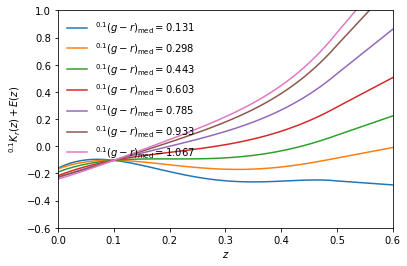

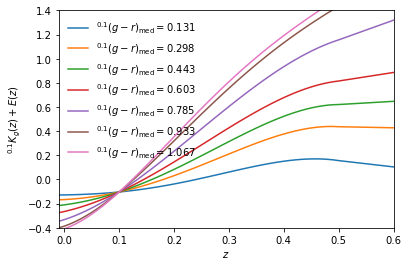

In [67]:
'''
Introduce K-correction work here.

The following cell of code is attributed to Alex Smith at Durham.
'''

class GAMA_KCorrection(object):
    
    def __init__(self, k_corr_file, z0=0.1, kind="linear"):

        """
        Colour-dependent polynomial fit to the GAMA K-correction (Fig. 13 of Smith+17), 
        used to convert between SDSS r-band Petrosian apparent magnitudes, and rest 
        frame absolute manigutues at z_ref = 0.1
        
        Args:
            k_corr_file: file of polynomial coefficients for each colour bin
            z0: reference redshift. Default value is z0=0.1
            kind: type of interpolation between colour bins,
                  e.g. "linear", "cubic". Default is "linear"
        """
        
        # read file of parameters of polynomial fit to k-correction
        # polynomial k-correction is of the form
        # A*(z-z0)^4 + B*(z-z0)^3 + C*(z-z0)^2 + D*(z-z0) + E 
        col_min, col_max, A, B, C, D, E, col_med = \
            np.loadtxt(k_corr_file, unpack=True)
    
        self.z0 = z0              # reference redshift
        self.nbins = len(col_min) # number of colour bins in file
        
        self.colour_min = np.min(col_med)
        self.colour_max = np.max(col_med)
        self.colour_med = col_med

        # functions for interpolating polynomial coefficients
        self.__A_interpolator = self.__initialize_parameter_interpolator(A, col_med, kind=kind)
        self.__B_interpolator = self.__initialize_parameter_interpolator(B, col_med, kind=kind)
        self.__C_interpolator = self.__initialize_parameter_interpolator(C, col_med, kind=kind)
        self.__D_interpolator = self.__initialize_parameter_interpolator(D, col_med, kind=kind)
        self.__E = E[0]

        # Linear extrapolation for z>0.5
        self.__X_interpolator = lambda x: None
        self.__Y_interpolator = lambda x: None
        self.__X_interpolator, self.__Y_interpolator = self.__initialize_line_interpolators() 

   
    def __initialize_parameter_interpolator(self, parameter, median_colour, kind="linear"):
        # returns function for interpolating polynomial coefficients, as a function of colour
        return interp1d(median_colour, parameter, kind=kind, fill_value="extrapolate")

    
    def __initialize_line_interpolators(self):
        # linear coefficients for z>0.5
        X = np.zeros(self.nbins)
        Y = np.zeros(self.nbins)
        
        # find X, Y at each colour
        redshift = np.array([0.48,0.5])
        arr_ones = np.ones(len(redshift))
        for i in range(self.nbins):
            if i <= 3:
                Q0 = 2.12
            else:
                Q0 = 0.8
                
            k = self.k(redshift, arr_ones*self.colour_med[i]) #+ Q0*(redshift-self.z0)
            X[i] = (k[1]-k[0]) / (redshift[1]-redshift[0])
            Y[i] = k[0] - X[i]*redshift[0]
        
        X_interpolator = interp1d(self.colour_med, X, kind='linear', fill_value="extrapolate")
        Y_interpolator = interp1d(self.colour_med, Y, kind='linear', fill_value="extrapolate")
        
        return X_interpolator, Y_interpolator


    def __A(self, colour):
        # coefficient of the z**4 term
        colour_clipped = np.clip(colour, self.colour_min, self.colour_max)
        return self.__A_interpolator(colour_clipped)

    def __B(self, colour):
        # coefficient of the z**3 term
        colour_clipped = np.clip(colour, self.colour_min, self.colour_max)
        return self.__B_interpolator(colour_clipped)

    def __C(self, colour):
        # coefficient of the z**2 term
        colour_clipped = np.clip(colour, self.colour_min, self.colour_max)
        return self.__C_interpolator(colour_clipped)

    def __D(self, colour):
        # coefficient of the z**1 term
        colour_clipped = np.clip(colour, self.colour_min, self.colour_max)
        return self.__D_interpolator(colour_clipped)

    def __X(self, colour):
        colour_clipped = np.clip(colour, self.colour_min, self.colour_max)
        return self.__X_interpolator(colour_clipped)

    def __Y(self, colour):
        colour_clipped = np.clip(colour, self.colour_min, self.colour_max)
        return self.__Y_interpolator(colour_clipped)


    def k(self, redshift, colour):
        """
        Polynomial fit to the GAMA K-correction for z<0.5
        The K-correction is extrapolated linearly for z>0.5

        Args:
            redshift: array of redshifts
            colour:   array of ^0.1(g-r) colour
        Returns:
            array of K-corrections
        """
        K = np.zeros(len(redshift))
        idx = redshift <= 0.5
        
        K[idx] = self.__A(colour[idx])*(redshift[idx]-self.z0)**4 + \
                 self.__B(colour[idx])*(redshift[idx]-self.z0)**3 + \
                 self.__C(colour[idx])*(redshift[idx]-self.z0)**2 + \
                 self.__D(colour[idx])*(redshift[idx]-self.z0) + self.__E 

        idx = redshift > 0.5
        
        K[idx] = self.__X(colour[idx])*redshift[idx] + self.__Y(colour[idx])
        
        if (colour[0] > 0.76):
            Q0 = 0.80
        else:
            Q0 = 2.12
                
        return K #- Q0*(redshift-self.z0)

def test_plots():

    kcorr_r = GAMA_KCorrection("k_corr_rband_z01.dat")
    kcorr_g = GAMA_KCorrection("k_corr_gband_z01.dat")

    z = np.arange(-0.01,0.601,0.01)
    cols = 0.130634, 0.298124, 0.443336, 0.603434, 0.784644, 0.933226, 1.06731
    
    # make r-band k-correction plot
    for c in cols:
        col = np.ones(len(z)) * c
        k = kcorr_r.k(z, col)
        plt.plot(z, k, label=r"$^{0.1}(g-r)_\mathrm{med}=%.3f$"%c)

    plt.xlabel(r"$z$")
    plt.ylabel(r"$^{0.1}K_r(z)+E(z)$")
    plt.xlim(0,0.6)
    plt.ylim(-0.6,1)
    plt.legend(loc="upper left").draw_frame(False)
    plt.show()

    # make g-band k-correction plot
    for c in cols:
        col = np.ones(len(z)) * c
        k = kcorr_g.k(z, col)
        plt.plot(z, k, label=r"$^{0.1}(g-r)_\mathrm{med}=%.3f$"%c)

    plt.xlabel(r"$z$")
    plt.ylabel(r"$^{0.1}K_g(z)+E(z)$")
    plt.xlim(-0.01,0.6)
    plt.ylim(-0.4,1.4)
    plt.legend(loc="upper left").draw_frame(False)
    plt.show()
        
if __name__ == "__main__":
    test_plots()
    

gama_kcorr_r = GAMA_KCorrection("k_corr_rband_z01.dat")
gama_kcorr_g = GAMA_KCorrection("k_corr_gband_z01.dat")

kcorr_r = GAMA_KCorrection("k_corr_rband_z01.dat")
kcorr_g = GAMA_KCorrection("k_corr_gband_z01.dat")

In [68]:
kcorr_r = GAMA_KCorrection("k_corr_rband_z01.dat")
kcorr_g = GAMA_KCorrection("k_corr_gband_z01.dat")

In [69]:
def colour_observer_func(colour_rest, colour_obs, z):
    '''
    Returns the difference between the colour from the function and the 
    actual observer-frame colour.
    
    Input:
           colour_rest = the rest-frame g-r colour of the galaxy.    [int, float, array]
           colour_obs = the observer-frame g-r colour of the galaxy. [int, float, array]
           z = the redshift of the galaxy.                           [int, float, array]
    '''
    #print('colour_observer_func')
    
    colour_observer_func = colour_observer(colour_rest, z)
    #print(colour_observer_func)
    #print(colour_obs)
    return colour_observer_func - colour_obs

def k_corr_data(data, params=None):
    '''
    This function finds the rest-frame colour of galaxies using Brent's method.
    From this, the K-corrections in the r and g bands are calculated.
    Input:
        data: the relevant dataset   [Astropy Table]
        params (optional): will generate an alternative 
    '''
    
    if params == None:
        data['G-R_REST'] = 0.0

        for i in range(len(data)):
            colour_obs_holder = data['G-R_OBS'][i]
            z_holder = data['Z'][i]

            try:
                root = optimize.brentq(colour_observer_func, -2, 5, args=(colour_obs_holder, z_holder))        
                data['G-R_REST'][i] = root

            except:
                pass
        
        '''
        FIX THIS PART FOR TWO COLOURS
        NB: No Need Now
       
        for i in tqdm(range(len(data))):
            if data['G-R_REST'][i] < 0.62:
                Q0 = 2.12
            else:
                Q0 = 0.8
        '''
        data['K_R'] = gama_kcorr_r.k(data['Z'], data['G-R_REST'])
        data['K_G'] = gama_kcorr_g.k(data['Z'], data['G-R_REST'])
       
        #data['K_R'] = gama_kcorr_r.k(data['Z'], data['G-R_REST'])
        #data['K_G'] = gama_kcorr_g.k(data['Z'], data['G-R_REST'])
    
    else:
        '''
        SOURCE: Table 1. and Eqn 1. in McNaught-Roberts et al. (2014)
        Values for (g-r)_0 = 0.553
        params=[-6.299, 14.76, -7.473, 1.847, -0.006801]
        '''
        
        data['K_R'] = params[0]*data['Z']**4 + params[1]*data['Z']**3 + params[2]*data['Z']**2 + params[3]*data['Z']**1 + params[4]*data['Z']**0

In [70]:
def mw_xtinct(ebv, band):
    '''
    A function to account for MW dust attenuation on observed fluxes. Taken from
    https://github.com/michaelJwilson/bgs-cmxsv/blob/main/py/bgs-cmxsv/mw_xtinct.py
    
    Input:
        EBV  : Extinction coefficient = (B-V)_obs - (B-V)_int     [Float]
        band : The relevant colour band (G, R, i, Z, Y)           [String] 
    '''
    
    #coeffs = {'G': 3.214, 'R': 2.165, 'i': 1.592, 'Z': 1.211, 'Y': 1.064}
    #Ab     = coeffs[band] * desiutil.dust.mwdust_transmission(, 'R', 'N')
    #return  10.**(-Ab / 2.5) 
    
    return desiutil.dust.mwdust_transmission(ebv, 'R', 'N')

def g_r_obs_func(data):
    '''
    Calculates observer-frame colour for a table given FLUX_R, FLUX_G and EBV.
    
    Input:
        data : the relevant dataset (such as deep_bright)         [Astropy Table]
    '''
    Fg = data['FLUX_G'] / mw_xtinct(data['EBV'], 'G')
    Fr = data['FLUX_R'] / mw_xtinct(data['EBV'], 'R')

    data['G-R_OBS'] = -2.5*np.log10(Fg/Fr)

In [71]:
import astropy
from astropy.table import Table


filename = 'bright_v0.0.fits'
hdul = astropy.io.fits.open(filename)

with fits.open(filename) as hdu:
    data = Table(hdu[1].data)

Text(0.5, 1.0, 'GAMA Fields')

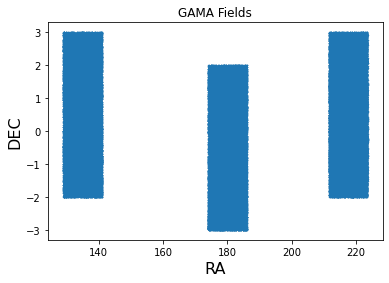

In [72]:
plt.scatter(data['RA'], data['DEC'], s=0.25)
plt.xlabel('RA', fontsize=16)
plt.ylabel('DEC', fontsize=16)
plt.title('GAMA Fields')

In [73]:
try:
    data.rename_column('RA', 'TARGET_RA')
    data.rename_column('DEC', 'TARGET_DEC')
    data.rename_column('ZGAMA', 'Z')
except:
    pass

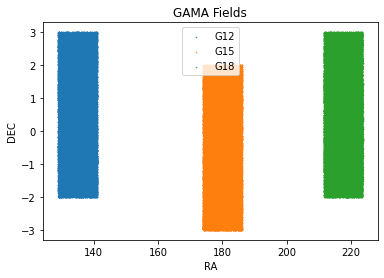

In [74]:
data['GFIELD'] = 0

for i in range(len(data)):
    if data['TARGET_RA'][i] < 150:
        data['GFIELD'][i] = 9
    elif (data['TARGET_RA'][i] > 150) and (data['TARGET_RA'][i] < 200):
        data['GFIELD'][i] = 12
    else:
        data['GFIELD'][i] = 15

G9 = data[data['GFIELD'] == 9]
G12 = data[data['GFIELD'] == 12]
G15 = data[data['GFIELD'] == 15]

plt.scatter(G9['TARGET_RA'], G9['TARGET_DEC'], s=0.25, label='G12')
plt.scatter(G12['TARGET_RA'], G12['TARGET_DEC'], s=0.25, label='G15')
plt.scatter(G15['TARGET_RA'], G15['TARGET_DEC'], s=0.25, label='G18')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.title('GAMA Fields')
plt.legend()
plt.show()

In [75]:
G9_ra_min, G9_ra_max = min(G9['TARGET_RA']), max(G9['TARGET_RA'])
G9_dec_min, G9_dec_max = min(G9['TARGET_DEC']), max(G9['TARGET_DEC'])

G12_ra_min, G12_ra_max = min(G12['TARGET_RA']), max(G12['TARGET_RA'])
G12_dec_min, G12_dec_max = min(G12['TARGET_DEC']), max(G12['TARGET_DEC'])

G15_ra_min, G15_ra_max = min(G15['TARGET_RA']), max(G15['TARGET_RA'])
G15_dec_min, G15_dec_max = min(G15['TARGET_DEC']), max(G15['TARGET_DEC'])

print(G9_ra_min, G9_ra_max)
print(G9_dec_min, G9_dec_max)
print(G12_ra_min, G12_ra_max)
print(G12_dec_min, G12_dec_max)
print(G15_ra_min, G15_ra_max)
print(G15_dec_min, G15_dec_max)

d_ra_min_array = [G9_ra_min, G12_ra_min, G15_ra_min]
d_ra_max_array = [G9_ra_max, G12_ra_max, G15_ra_max]
d_dec_min_array = [G9_dec_min, G12_dec_min, G15_dec_min]
d_dec_max_array = [G9_dec_max, G12_dec_max, G15_dec_max]

129.00007574 140.99960692
-1.99999154 2.99999935
174.00046468 185.99943836
-2.99990056 1.99991296
211.50030624 223.49985581
-1.99995686 2.99995944


Text(0, 0.5, 'r_SDSS')

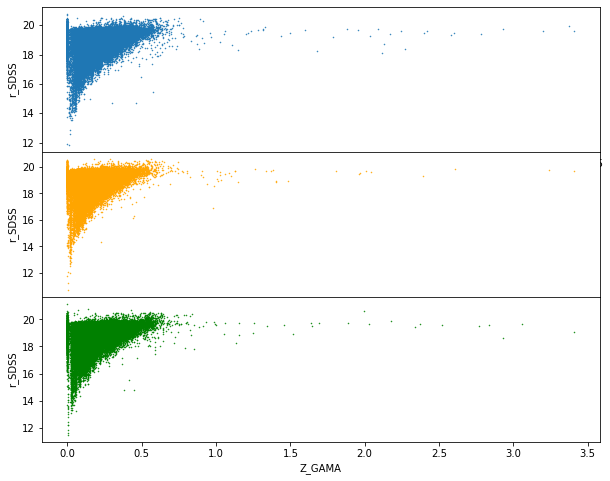

In [76]:
fig, ax = plt.subplots(3,1, figsize=(10,8))
ax[0].scatter(G9['Z'], G9['RMAG_DRED_SDSS'], s=0.25)
ax[1].scatter(G12['Z'], G12['RMAG_DRED_SDSS'], c='orange', s=0.25)
ax[2].scatter(G15['Z'], G15['RMAG_DRED_SDSS'], c='green', s=0.25)
plt.subplots_adjust(wspace=0, hspace=0)
plt.xlabel('Z_GAMA')
ax[0].set_ylabel('r_SDSS')
ax[1].set_ylabel('r_SDSS')
ax[2].set_ylabel('r_SDSS')

Text(0, 0.5, 'r_petro')

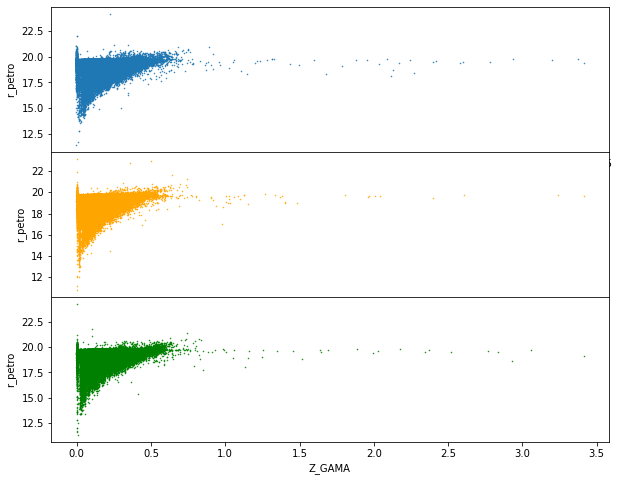

In [77]:
fig, ax = plt.subplots(3,1, figsize=(10,8))
ax[0].scatter(G9['Z'], G9['R_PETRO'], s=0.25)
ax[1].scatter(G12['Z'], G12['R_PETRO'], c='orange', s=0.25)
ax[2].scatter(G15['Z'], G15['R_PETRO'], c='green', s=0.25)
plt.subplots_adjust(wspace=0, hspace=0)
plt.xlabel('Z_GAMA')
ax[0].set_ylabel('r_petro')
ax[1].set_ylabel('r_petro')
ax[2].set_ylabel('r_petro')

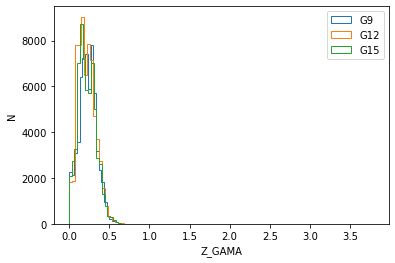

In [78]:
bins = 100
plt.hist(G9['Z'], bins=bins, histtype='step', label='G9')
plt.hist(G12['Z'], bins=bins, histtype='step', label='G12')
plt.hist(G15['Z'], bins=bins, histtype='step', label='G15')
plt.xlabel('Z_GAMA')
plt.ylabel('N')
plt.legend()
plt.show()

In [79]:
'''
Next selection cuts
'''

print(len(data))
data = data[data['SURVEY_CLASS'] >= 4]
data = data[data['Z'] > 0.001]
data = data[data['Z'] < 0.6]
data = data[data['RMAG_DRED_SDSS'] < mag_limit]
data = data[data['R_PETRO'] < mag_limit]

print(len(data))

G9 = data
G9 = G9[G9['TARGET_RA'] < 150]
G9_ra_min, G9_ra_max = min(G9['TARGET_RA']), max(G9['TARGET_RA'])
G9_dec_min, G9_dec_max = min(G9['TARGET_DEC']), max(G9['TARGET_DEC'])

G12 = data
G12 = G12[G12['TARGET_RA'] > 150]
G12 = G12[G12['TARGET_RA'] < 200]
G12_ra_min, G12_ra_max = min(G12['TARGET_RA']), max(G12['TARGET_RA'])
G12_dec_min, G12_dec_max = min(G12['TARGET_DEC']), max(G12['TARGET_DEC'])

G15 = data
G15 = G15[G15['TARGET_RA'] > 200]
G15_ra_min, G15_ra_max = min(G15['TARGET_RA']), max(G15['TARGET_RA'])
G15_dec_min, G15_dec_max = min(G15['TARGET_DEC']), max(G15['TARGET_DEC'])

d_ra_min_array = [G9_ra_min, G12_ra_min, G15_ra_min]
d_ra_max_array = [G9_ra_max, G12_ra_max, G15_ra_max]
d_dec_min_array = [G9_dec_min, G12_dec_min, G15_dec_min]
d_dec_max_array = [G9_dec_max, G12_dec_max, G15_dec_max]

188032
129532


Text(0.5, 1.0, 'GAMA Fields')

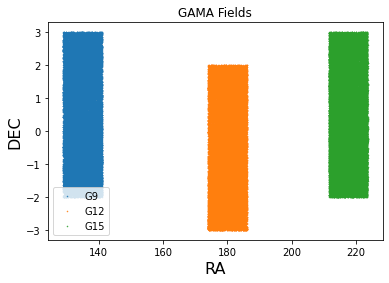

In [80]:
plt.scatter(G9['TARGET_RA'], G9['TARGET_DEC'], s=0.25, label='G9')
plt.scatter(G12['TARGET_RA'], G12['TARGET_DEC'], s=0.25, label='G12')
plt.scatter(G15['TARGET_RA'], G15['TARGET_DEC'], s=0.25, label='G15')
plt.xlabel('RA', fontsize=16)
plt.ylabel('DEC', fontsize=16)
plt.legend()
plt.title('GAMA Fields')

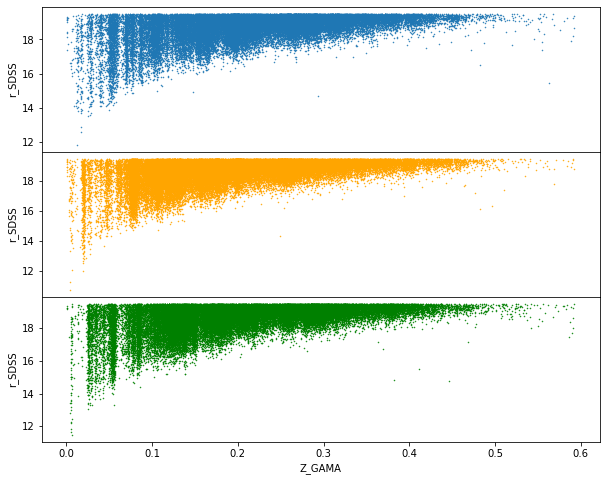

In [81]:
fig, ax = plt.subplots(3,1, figsize=(10,8))
ax[0].scatter(G9['Z'], G9['RMAG_DRED_SDSS'], s=0.25)
ax[1].scatter(G12['Z'], G12['RMAG_DRED_SDSS'], c='orange', s=0.25)
ax[2].scatter(G15['Z'], G15['RMAG_DRED_SDSS'], c='green', s=0.25)
plt.subplots_adjust(wspace=0, hspace=0)
plt.xlabel('Z_GAMA')
ax[0].set_ylabel('r_SDSS')
ax[1].set_ylabel('r_SDSS')
ax[2].set_ylabel('r_SDSS')
plt.show()

Text(0, 0.5, 'r_petro')

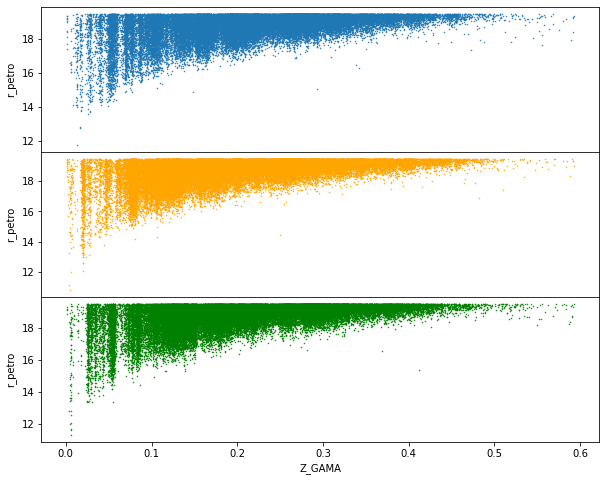

In [82]:
fig, ax = plt.subplots(3,1, figsize=(10,8))
ax[0].scatter(G9['Z'], G9['R_PETRO'], s=0.25)
ax[1].scatter(G12['Z'], G12['R_PETRO'], c='orange', s=0.25)
ax[2].scatter(G15['Z'], G15['R_PETRO'], c='green', s=0.25)
plt.subplots_adjust(wspace=0, hspace=0)
plt.xlabel('Z_GAMA')
ax[0].set_ylabel('r_petro')
ax[1].set_ylabel('r_petro')
ax[2].set_ylabel('r_petro')

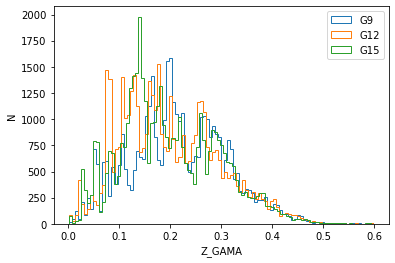

In [83]:
bins = 100
plt.hist(G9['Z'], bins=bins, histtype='step', label='G9')
plt.hist(G12['Z'], bins=bins, histtype='step', label='G12')
plt.hist(G15['Z'], bins=bins, histtype='step', label='G15')
plt.xlabel('Z_GAMA')
plt.ylabel('N')
plt.legend()
plt.show()

In [84]:
#data = ascii.read('BGS_deep_bright.csv', format='csv')
#data = ascii.read('basic_GAMA_dataset.csv', format='csv')


In [85]:
# = data[data['TARGET_RA'] > 200]

In [86]:
#plt.scatter(data['TARGET_RA'], data['TARGET_DEC'], s=0.25)

In [87]:
#data = Table(np.random.choice(data, int(len(data)*0.075)))
#print(len(data))

Text(0, 0.5, '$r_{SDSS} - r_{petro}$')

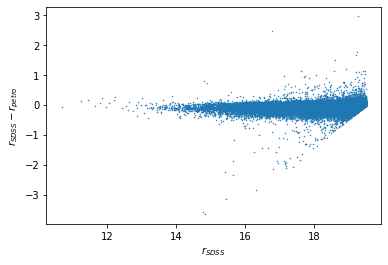

In [88]:
plt.scatter(data['RMAG_DRED_SDSS'], data['RMAG_DRED_SDSS'] - data['R_PETRO'], s=0.25)
plt.xlabel(r'$r_{SDSS}$')
plt.ylabel(r'$r_{SDSS} - r_{petro}$')

In [89]:
def k_corr_data(data, params=None):
    '''
    This function finds the rest-frame colour of galaxies using Brent's method.
    From this, the K-corrections in the r and g bands are calculated.
    Input:
        data: the relevant dataset   [Astropy Table]
        params (optional): will generate an alternative 
    '''
    
    if params == None:
        print('Params = None')
        data['G-R_REST'] = 0.0

        for i in range(len(data)):
            colour_obs_holder = data['G-R_OBS'][i]
            z_holder = data['Z'][i]
            
            try:
                root = optimize.brentq(colour_observer_func, -3, 6, args=(colour_obs_holder, z_holder))        
                data['G-R_REST'][i] = root
            
            except:
                print('pass')
                pass
        
        '''
        FIX THIS PART FOR TWO COLOURS
        NB: No Need Now
       
        for i in tqdm(range(len(data))):
            if data['G-R_REST'][i] < 0.62:
                Q0 = 2.12
            else:
                Q0 = 0.8
        '''
        data['K_R'] = gama_kcorr_r.k(data['Z'], data['G-R_REST'])
        data['K_G'] = gama_kcorr_g.k(data['Z'], data['G-R_REST'])
       
        #data['K_R'] = gama_kcorr_r.k(data['Z'], data['G-R_REST'])
        #data['K_G'] = gama_kcorr_g.k(data['Z'], data['G-R_REST'])
    
    else:
        '''
        SOURCE: Table 1. and Eqn 1. in McNaught-Roberts et al. (2014)
        Values for (g-r)_0 = 0.553
        params=[-6.299, 14.76, -7.473, 1.847, -0.006801]
        '''
        
        data['K_R'] = params[0]*data['Z']**4 + params[1]*data['Z']**3 + params[2]*data['Z']**2 + params[3]*data['Z']**1 + params[4]*data['Z']**0

In [90]:
#data_storage = data

In [91]:
data = Table(np.random.choice(data_storage, int(len(data_storage)*0.05)))
print(len(data))

8986


In [92]:
#data = data_storage

try:
    data['FLUX_G_MW'] = data['FLUX_G'] / mw_xtinct(data['EBV'], 'G')
    data['FLUX_R_MW'] = data['FLUX_R'] / mw_xtinct(data['EBV'], 'R')
    #data['FLUX_Z_MW'] = data['FLUX_Z'] / mw_xtinct(data['EBV'], 'Z')
    data['FIBERFLUX_G_MW'] = data['FIBERFLUX_G'] / mw_xtinct(data['EBV'], 'G')
    data['FIBERFLUX_R_MW'] = data['FIBERFLUX_R'] / mw_xtinct(data['EBV'], 'R')
    #data['FIBERFLUX_Z_MW'] = data['FIBERFLUX_Z'] / mw_xtinct(data['EBV'], 'Z')

    g_r_obs_func(data)
    k_corr_data(data, params=None)
except:
    print('Entered Except Clause.')
    data['G-R_OBS'] = data['GMAG_DRED_SDSS'] - data['RMAG_DRED_SDSS']
    k_corr_data(data, params=None)





Entered Except Clause.
Params = None


In [93]:
len(data)

8986

0.1
0.5


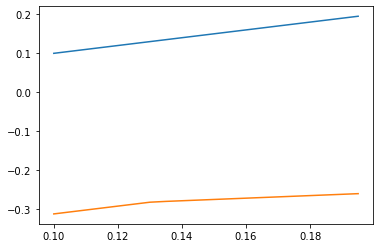

In [94]:
gmr_rest = np.arange(0.1, 0.2, 0.005)
z = np.ones(len(gmr_rest)) * 0.1
print(z[0])
gmr_obs = gmr_rest + gama_kcorr_r.k(z, gmr_rest) - gama_kcorr_g.k(z, gmr_rest)

z = np.ones(len(gmr_rest)) * 0.5
print(z[0])
gmr_obs2 = gmr_rest + gama_kcorr_r.k(z, gmr_rest) - gama_kcorr_g.k(z, gmr_rest)

plt.plot(gmr_rest, gmr_obs)
plt.plot(gmr_rest, gmr_obs2)

Text(0, 0.5, 'GMR_REST')

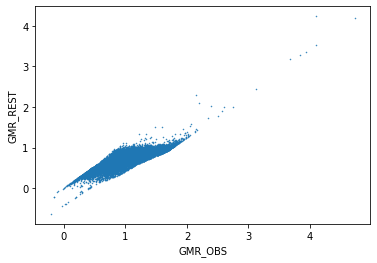

In [95]:
plt.scatter(data['G-R_OBS'], data['G-R_REST'], s=0.25)
plt.xlabel('GMR_OBS')
plt.ylabel('GMR_REST')

In [96]:
def app_mag_calc(data):
    #data['MW_CORRECTION_R'] = mw_xtinct(data['EBV'], band='R')
    try:
        data['MODEL_MAG'] = 22.5 - 2.5*np.log10(data['FLUX_R_MW']) #/ data['MW_CORRECTION_R'])
        data['MODEL_FIBRE_MAG'] = 22.5 - 2.5*np.log10(data['FIBERFLUX_R_MW']) #/ data['MW_CORRECTION_R'])
    except:
        # use Petrosian magnitude
        data['MODEL_MAG'] = data['R_PETRO']
        data['MODEL_FIBRE_MAG'] = data['FIBERMAG_R']
        
def abs_mag_calc(data):
    lum_dist_list = cosmo.luminosity_distance(data['Z']).value
    abs_mag_list = data['MODEL_MAG'] - (5 * np.log10(lum_dist_list)) - 25
    data['M_R'] = abs_mag_list - data['K_R']

In [97]:
app_mag_calc(data)
abs_mag_calc(data)

In [98]:
#data['M_R_0.1'] = data['M_R']
#data['M_R'] = data['M_R_0.1'] + gama_kcorr_r.k(np.zeros(len(data)), data['G-R_REST'])


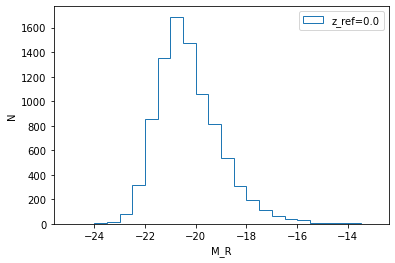

In [99]:
#plt.hist(data['M_R_0.1'], histtype='step', bins=np.arange(-25, -12.5, 0.5), label='z_ref=0.1')
plt.hist(data['M_R'], histtype='step', bins=np.arange(-25, -12.5, 0.5), label='z_ref=0.0')
plt.xlabel('M_R')
plt.ylabel('N')
plt.legend()

In [100]:
print(len(data), min(data['Z']), max(data['Z']))

8986 0.00123 0.59908


In [101]:
#num_of_tiles = len(np.unique(data['TILEID']))
#dia = 3 # diameter of tile, double check this
#deg_sq = (dia/2)**2 *np.pi * num_of_tiles
deg_sq = 12*5*3

sky_fraction = deg_sq / 41253 # total sq deg. on sky

xspace = np.linspace(-22.5, -14.99, 100000) # for plotting Schechter
xedges = np.arange(-23, -14.99, 0.5) # for plotting LF

In [102]:
def schechter(M, Mstar, alpha, phistar):
    return 0.4*np.log(10)*phistar * (10**(0.4*(Mstar-M)))**(alpha+1) * np.exp(-10**(0.4*(Mstar-M)))

def log_schechter(M, Mstar, alpha, phistar):
    return np.log10(0.4*np.log(10)*phistar * (10**(0.4*(Mstar-M)))**(alpha+1) * np.exp(-10**(0.4*(Mstar-M))))

In [103]:
def diff_func(z, abs_mag, mag_limit, colour_rest, params=None):

    lum_dist = cosmo.luminosity_distance(z).value
    
    if params==None:
        if isinstance(colour_rest, int) or isinstance(colour_rest, float):
            colour_rest = np.array([colour_rest])
        else:
            colour_rest = np.array(colour_rest)

        if isinstance(z, int) or isinstance(z, float):
            z = np.array([z])
        else:
            z = np.array(z)
        
        #app_mag = abs_mag + (5 * np.log10(lum_dist)) + 25 + gama_kcorr_r.k_shift(z, colour_rest)
        app_mag = abs_mag + (5 * np.log10(lum_dist)) + 25 + gama_kcorr_r.k(z, colour_rest)
        
    else:
        K_r = params[0]*z**4 + params[1]*z**3 + params[2]*z**2 + params[3]*z**1 + params[4]*z**0 
        app_mag = abs_mag + (5 * np.log10(lum_dist)) + 25 + K_r
    
    return app_mag - mag_limit
    
    
def vmax_brent(data, lower_z, upper_z, mag_limit, params=None):
    abs_mag = data['M_R']
    colour_rest = data['G-R_REST']

    #min_z = 0
    #max_z = 0.6
    #print(min_z, max_z)
    
    root = scipy.optimize.brentq(diff_func, min_z, max_z, args=(abs_mag, mag_limit, colour_rest))
    
    #z_lim_min = np.min([root, lower_z])
    z_lim_min = np.min([lower_z])
    z_lim_max = np.min([root, upper_z])
    #print('z_lim_max', z_lim_max)
    vol = h**3 * (cosmo.comoving_volume(z_lim_max).value - cosmo.comoving_volume(z_lim_min).value)
    return vol #, root

In [104]:
min_z = min(data['Z'])
max_z = max(data['Z'])

data['V'] = 0.0
data['VMAX'] = 0.0 
# quick test of function
i = 0
data['V'][i] = h**3 * (cosmo.comoving_volume(data['Z'][i]).value - cosmo.comoving_volume(min_z).value)
data['VMAX'][i] = vmax_brent(data[i], min_z, max_z, mag_limit, params=None)

In [105]:
len(data)

8986

In [106]:
#data = Table(np.random.choice(data_storage, int(len(data_storage)*0.05)))
print(len(data))

8986


In [107]:
min_z = min(data['Z'])
max_z = max(data['Z'])

data['V'] = 0.0
data['VMAX'] = 0.0 

pass_array = []
roots = []
for i in tqdm(range(len(data))):
    try:        
        data['V'][i] = h**3 * (cosmo.comoving_volume(data['Z'][i]).value - cosmo.comoving_volume(min_z).value)
        data['VMAX'][i] = vmax_brent(data[i], min_z, max_z, mag_limit, params=None)
    except:
        pass_array.append(i)

print(len(data[data['V'] > data['VMAX']]))

100%|██████████| 8986/8986 [00:56<00:00, 157.89it/s]

2502


In [108]:
'''
figure out what the problem is here (635 VMAX == 0)
'''

print(len(data[data['VMAX'] == 0]))
data = data[data['VMAX'] != 0]

10


In [116]:
data['V_VMAX'] = data['V']/data['VMAX']

In [117]:
#data = data[data['V_VMAX'] <= 1]

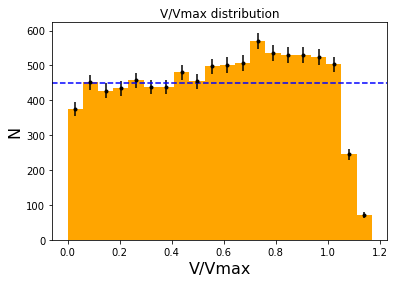

In [118]:
n, bins, _ = plt.hist(data['V_VMAX'], bins=20, color='orange')
mid = 0.5*(bins[1:] + bins[:-1])
plt.errorbar(mid, n, yerr=np.sqrt(n), fmt='.k')
plt.axhline(np.mean(n), ls='--', color='b')
plt.xlabel('V/Vmax',fontsize=16)
plt.ylabel('N', fontsize=16)
plt.title('V/Vmax distribution')
plt.show()

In [112]:
data['M_R_0.1'] = data['M_R']
data['M_R'] = data['M_R_0.1'] + gama_kcorr_r.k(np.zeros(len(data)), data['G-R_REST'])

In [113]:
min_z = min(data['Z'])
max_z = max(data['Z'])

data['V'] = 0.0
data['VMAX'] = 0.0 
# quick test of function
i = 0
data['V'][i] = h**3 * (cosmo.comoving_volume(data['Z'][i]).value - cosmo.comoving_volume(min_z).value)
data['VMAX'][i] = vmax_brent(data[i], min_z, max_z, mag_limit, params=None)

In [114]:
min_z = min(data['Z'])
max_z = max(data['Z'])

data['V'] = 0.0
data['VMAX'] = 0.0 

pass_array = []
roots = []
for i in tqdm(range(len(data))):
    try:        
        data['V'][i] = h**3 * (cosmo.comoving_volume(data['Z'][i]).value - cosmo.comoving_volume(min_z).value)
        data['VMAX'][i] = vmax_brent(data[i], min_z, max_z, mag_limit, params=None)
    except:
        pass_array.append(i)

print(len(data[data['V'] > data['VMAX']]))

100%|██████████| 8976/8976 [00:54<00:00, 164.26it/s]

770


8


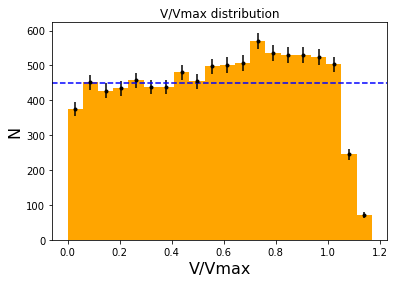

In [115]:
print(len(data[data['VMAX'] == 0]))
data = data[data['VMAX'] != 0]
data['V_VMAX'] = data['V']/data['VMAX']

n, bins, _ = plt.hist(data['V_VMAX'], bins=20, color='orange')
mid = 0.5*(bins[1:] + bins[:-1])
plt.errorbar(mid, n, yerr=np.sqrt(n), fmt='.k')
plt.axhline(np.mean(n), ls='--', color='b')
plt.xlabel('V/Vmax',fontsize=16)
plt.ylabel('N', fontsize=16)
plt.title('V/Vmax distribution')
plt.show()

In [57]:
# investigate V > Vmax issue

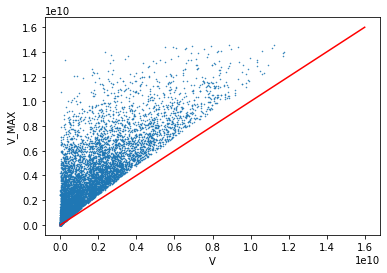

In [58]:
plt.scatter(data['V'], data['VMAX'], s=0.25)
plt.plot([0, 1.6e10], [0, 1.6e10], color='r')
plt.xlabel('V')
plt.ylabel('V_MAX')
plt.xlim(0, 0.05e10)
plt.show()

In [59]:
data_t = data[data['V'] > data['VMAX']]

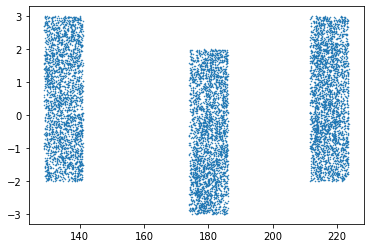

In [60]:
plt.scatter(data['TARGET_RA'], data['TARGET_DEC'], s=0.25)
plt.scatter(data_t['TARGET_RA'], data_t['TARGET_DEC'], s=0.25)

No handles with labels found to put in legend.


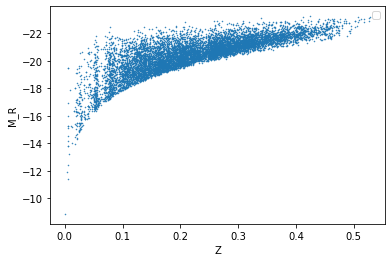

In [61]:
plt.scatter(data['Z'], data['M_R'], s=0.25)
plt.scatter(data_t['Z'], data_t['M_R'], s=0.25)
plt.gca().invert_yaxis()
plt.xlabel('Z')
plt.ylabel('M_R')
plt.legend()

In [62]:
data.dtype.descr

[('CATAID', '<i4'),
 ('OBJID', '<i8'),
 ('TARGET_RA', '<f8'),
 ('TARGET_DEC', '<f8'),
 ('FIBERMAG_R', '<f4'),
 ('R_PETRO', '<f4'),
 ('SURVEY_CODE', '<i2'),
 ('NQ', '<i2'),
 ('NQ2_FLAG', '<i2'),
 ('SPECID', '<U33'),
 ('VEL_ERR', '<f4'),
 ('NUM_GAMA_SPEC', '<i2'),
 ('R_SB', '<f4'),
 ('SG_SEP', '<f4'),
 ('SG_SEP_JK', '<f4'),
 ('K_AUTO', '<f4'),
 ('RADIO_FLUX', '<f4'),
 ('HATLAS_FLAG', '<i2'),
 ('AREA_FLAG', '<i2'),
 ('TARGET_FLAGS', '<i2'),
 ('SURVEY_OLDCLASS', '<i2'),
 ('SURVEY_CLASS', '<i2'),
 ('PRIORITY_CLASS', '<i2'),
 ('NEIGHBOUR_CLASS', '<i2'),
 ('TC_V11_ID', '<i4'),
 ('MASK_IC_10', '<f4'),
 ('MASK_IC_12', '<f4'),
 ('VIS_CLASS', '<i2'),
 ('VIS_CLASS_USER', '<U11'),
 ('Z', '<f4'),
 ('UMAG_DRED_SDSS', '<f4'),
 ('GMAG_DRED_SDSS', '<f4'),
 ('RMAG_DRED_SDSS', '<f4'),
 ('IMAG_DRED_SDSS', '<f4'),
 ('ZMAG_DRED_SDSS', '<f4'),
 ('BGS_A_SUCCESS', '|b1'),
 ('BGS_A_WEIGHT', '<f8'),
 ('BGS_Z_SUCCESS', '|b1'),
 ('BGS_Z_WEIGHT', '<f8'),
 ('GFIELD', '<i8'),
 ('G-R_OBS', '<f4'),
 ('G-R_REST', '<f8'),

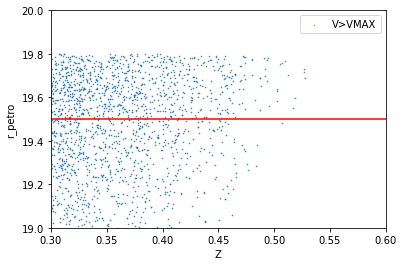

In [63]:
plt.scatter(data['Z'], data['R_PETRO'], s=0.25)
plt.scatter(data_t['Z'], data_t['R_PETRO'], s=0.25, label='V>VMAX')
plt.xlim(0.3, 0.6)
plt.ylim(19, 20)
plt.axhline(19.5, color='r')
plt.xlabel('Z')
plt.ylabel('r_petro')
plt.legend()

In [139]:
data_t[0]

CATAID,OBJID,TARGET_RA,TARGET_DEC,FIBERMAG_R,R_PETRO,SURVEY_CODE,NQ,NQ2_FLAG,SPECID,VEL_ERR,NUM_GAMA_SPEC,R_SB,SG_SEP,SG_SEP_JK,K_AUTO,RADIO_FLUX,HATLAS_FLAG,AREA_FLAG,TARGET_FLAGS,SURVEY_OLDCLASS,SURVEY_CLASS,PRIORITY_CLASS,NEIGHBOUR_CLASS,TC_V11_ID,MASK_IC_10,MASK_IC_12,VIS_CLASS,VIS_CLASS_USER,Z,UMAG_DRED_SDSS,GMAG_DRED_SDSS,RMAG_DRED_SDSS,IMAG_DRED_SDSS,ZMAG_DRED_SDSS,BGS_A_SUCCESS,BGS_A_WEIGHT,BGS_Z_SUCCESS,BGS_Z_WEIGHT,GFIELD,G-R_OBS,G-R_REST,K_R,K_G,MODEL_MAG,MODEL_FIBRE_MAG,M_R,V,VMAX,V_VMAX
int32,int64,float64,float64,float32,float32,int16,int16,int16,str33,float32,int16,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,int16,int32,float32,float32,int16,str11,float32,float32,float32,float32,float32,float32,bool,float64,bool,float64,int64,float32,float64,float64,float64,float32,float32,float64,float64,float64,float64
22287,588848901521932516,176.96489788,1.11011021,20.345129,19.780317,5,4,0,G12_Y2_032_044,70.220245,1,21.60892,0.357769,-9.99,-9.99,-9.99,0,2,15512,6,5,2,0,22287,0.0,0.0,255,xxx,0.25953,22.5683,21.228092,19.755274,19.21999,18.87208,True,1.0,True,1.0,15,1.4728184,0.9961261729150185,0.0013955388403610325,0.4780877405591315,19.780317,20.345129,-20.062084957961233,1682933658.8457434,1514035285.6923153,1.1115551102074854


In [138]:
i = 0
vmax_brent(data_t[i], min_z, max_z, mag_limit, params=None)

1514035285.6923153

In [141]:
print(min_z, max_z, mag_limit, data_t[i]['Z'])

0.00101 0.59908 19.8 0.25953


In [136]:
data_t

CATAID,OBJID,TARGET_RA,TARGET_DEC,FIBERMAG_R,R_PETRO,SURVEY_CODE,NQ,NQ2_FLAG,SPECID,VEL_ERR,NUM_GAMA_SPEC,R_SB,SG_SEP,SG_SEP_JK,K_AUTO,RADIO_FLUX,HATLAS_FLAG,AREA_FLAG,TARGET_FLAGS,SURVEY_OLDCLASS,SURVEY_CLASS,PRIORITY_CLASS,NEIGHBOUR_CLASS,TC_V11_ID,MASK_IC_10,MASK_IC_12,VIS_CLASS,VIS_CLASS_USER,Z,UMAG_DRED_SDSS,GMAG_DRED_SDSS,RMAG_DRED_SDSS,IMAG_DRED_SDSS,ZMAG_DRED_SDSS,BGS_A_SUCCESS,BGS_A_WEIGHT,BGS_Z_SUCCESS,BGS_Z_WEIGHT,GFIELD,G-R_OBS,G-R_REST,K_R,K_G,MODEL_MAG,MODEL_FIBRE_MAG,M_R,V,VMAX,V_VMAX
int32,int64,float64,float64,float32,float32,int16,int16,int16,str33,float32,int16,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,int16,int32,float32,float32,int16,str11,float32,float32,float32,float32,float32,float32,bool,float64,bool,float64,int64,float32,float64,float64,float64,float32,float32,float64,float64,float64,float64
22287,588848901521932516,176.96489788,1.11011021,20.345129,19.780317,5,4,0,G12_Y2_032_044,70.220245,1,21.60892,0.357769,-9.99,-9.99,-9.99,0,2,15512,6,5,2,0,22287,0.0,0.0,255,xxx,0.25953,22.5683,21.228092,19.755274,19.21999,18.87208,True,1.0,True,1.0,15,1.4728184,0.9961261729150185,0.0013955388403610325,0.4780877405591315,19.780317,20.345129,-20.062084957961233,1682933658.8457434,1514035285.6923153,1.1115551102074854
569870,588848899393716352,220.95236821,-0.42678404,20.340828,19.688112,5,4,0,G15_Y3_042_130,39.76893,1,21.540361,0.27397728,-9.99,-9.99,-9.99,0,2,7184,3,5,2,3,569870,0.0,0.0,0,xxx,0.27073,22.397907,20.886421,19.727482,19.350187,19.069332,True,1.0,True,1.0,18,1.1589394,0.7499758247405827,-0.07801084981379361,0.3309526870178892,19.688112,20.340828,-20.180521328168226,1896336378.7941787,1849383509.3400517,1.0253883898158485
3628715,587729151450546768,135.60425303,-0.86943654,20.695837,19.585814,5,4,0,G09_Y3_011_110,76.74744,1,22.819052,0.7762375,-9.99,-9.99,-9.99,0,2,7184,3,5,2,0,527069,0.0,0.0,255,xxx,0.41435,22.126772,21.159084,19.611399,19.022963,18.630466,True,1.0,True,1.0,12,1.5476856,0.8418390554106523,0.09569152614401916,0.801538093902312,19.585814,20.695837,-21.54285387098409,6168838588.798823,5997414859.013755,1.0285829367844095
544276,588848898854093299,214.59629414,-0.89968261,20.935719,19.75307,5,3,0,G15_Y4_236_370,48.235756,2,22.861288,1.1838245,-9.99,-9.99,-9.99,0,2,7184,3,5,2,0,544276,0.0,0.0,255,xxx,0.40695,21.542503,20.754795,19.700806,19.262316,18.918093,True,1.0,True,1.0,18,1.0539894,0.48885322004648474,-0.23139753723807857,0.3337386531158273,19.75307,20.935719,-21.001688938208765,5874176562.576787,4888908476.928448,1.2015313009637998
423498,587728879795175917,135.31537794,2.96945927,20.433945,19.59727,5,4,0,G09_Y3_002_271,50.31692,1,22.08986,0.51646423,-9.99,-9.99,-9.99,0,2,7248,4,5,2,2,423498,0.0,0.0,255,xxx,0.35617,26.018393,21.350056,19.60752,19.004677,18.53254,True,1.0,True,1.0,12,1.7425365,1.0432031189423165,0.11947807465093435,0.8188115005084224,19.59727,20.433945,-21.164327259135526,4077718128.1305256,4070387743.271132,1.0018009057912263
186668,587725041704894681,185.37103283,-1.60721652,20.229614,19.676712,5,4,0,G12_Y2_005_060,38.42042,3,21.568506,0.2798233,-9.99,-9.99,-9.99,0,2,15512,6,5,2,1,186668,0.0,0.0,255,xxx,0.29158,22.434874,20.823694,19.673122,19.273222,19.055805,True,1.0,True,1.0,15,1.1505718,0.708177432205285,-0.0938477319297372,0.34854665898509496,19.676712,20.229614,-20.362543285265478,2336611576.865136,2267523716.5433693,1.0304684179564327
231726,587726014534385819,185.3222607,1.96610698,20.642677,19.648092,5,4,0,G12_Y2_040_290,55.017426,1,22.80546,1.1580772,-9.99,-9.99,-9.99,0,2,15512,6,5,2,1,231726,0.0,0.0,0,xxx,0.4147,25.286152,21.037712,19.583155,19.089045,18.631374,True,1.0,True,1.0,15,1.4545574,0.7799340175830792,0.04150405257538431,0.7161274538155475,19.648092,20.642677,-21.428583012018432,6182985803.678849,5715485535.592889,1.0817953724446727
144706,587724650868113755,181.00716788,-1.30915582,20.35977,19.719278,5,4,0,G12_Y3_015_398,68.978806,3,21.930006,0.50164986,-9.99,-9.99,-9.99,0,2,15512,6,5,2,0,144706,0.0,0.0,255,xxx,

In [86]:
#ascii.write(data, 'new_GAMA_dataset_ke.csv', format='csv', fast_writer=False, overwrite=True)

In [ ]:
data = ascii.read('new_GAMA_dataset_ke.csv', format='csv')

In [ ]:
plt.hist(data['Z'], bins=100)
plt.xlabel('Z', fontsize=16)
plt.ylabel('N', fontsize=16)
plt.title('N(Z) GAMA')
plt.show()

In [ ]:
plt.hist(data['Z'], bins=200)
plt.xlim(-0.01, 0.01)
plt.show()

In [ ]:
i = 0
print(data['RMAG'][i])
print(data['RMAG_DRED'][i])
print(data['MODEL_MAG'][i])
print(data['MODEL_FIBRE_MAG'][i])

In [ ]:
#ascii.write(data, 'basic_GAMA_dataset_ke.csv', format='csv', fast_writer=False, overwrite=True)

In [ ]:
#ascii.write(data, 'basic_GAMA_dataset_ke_G15.csv', format='csv', fast_writer=False, overwrite=True)

In [ ]:
#ascii.write(data, 'BGS_deep_bright_ke0.csv', format='csv', fast_writer=False)

In [ ]:
'''
test V/Vmax for e-correction changes
'''

In [ ]:
c = 3*10**5
data = data[c*data['Z'] > 500]
data = data[data['Z'] < 0.6]
data = data[data['DELTACHI2'] > 40]
data = data[data['SPECTYPE'] != 'STAR']
data = data[data['ZWARN'] == 0]
data = data[data['ZERR'] < 0.0005 * (1+data['Z'])]

n, bins, _ = plt.hist(data['V_VMAX'], bins=20, color='orange')
mid = 0.5*(bins[1:] + bins[:-1])
plt.errorbar(mid, n, yerr=np.sqrt(n), fmt='.k')
plt.axhline(np.mean(n), ls='--', color='b')
plt.xlabel('V/Vmax',fontsize=16)
plt.ylabel('N', fontsize=16)
plt.title('V/Vmax distribution - full')
plt.show()

In [ ]:
'''
Test of old dust function vs. new one
'''
plt.scatter(data['FLUX_R_MW'], data['FLUX_R_MW_NEW'], s=0.25)
plt.xlim(0, 100)
plt.ylim(0, 100)

In [ ]:
plt.scatter(data['TARGET_RA'], data['TARGET_DEC'])

In [ ]:
data = ascii.read('new_GAMA_dataset_ke.csv', format='csv')

In [ ]:
ascii.write(data, 'new_GAMA_dataset_ke.csv', format='csv', fast_writer=False, overwrite=True)

In [ ]:
data['GFIELD'] = 0

for i in range(len(data)):
    if data['TARGET_RA'][i] < 150:
        data['GFIELD'][i] = 12
    elif (data['TARGET_RA'][i] > 150) and (data['TARGET_RA'][i] < 200):
        data['GFIELD'][i] = 15
    else:
        data['GFIELD'][i] = 18

G12 = data[data['GFIELD'] == 12]
G15 = data[data['GFIELD'] == 15]
G18 = data[data['GFIELD'] == 18]

plt.scatter(g12['TARGET_RA'], g12['TARGET_DEC'], s=0.25, label='G12')
plt.scatter(g15['TARGET_RA'], g15['TARGET_DEC'], s=0.25, label='G15')
plt.scatter(g18['TARGET_RA'], g18['TARGET_DEC'], s=0.25, label='G18')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.legend()
plt.show()